# **Using Watershed Segmentation to Extract Out Cell Regions from Images for Further Analysis**

#### *The first step in this workflow is the updated installation of any additional libraries to the user's version of Python:*

In [1]:
pip install --upgrade --user numpy matplotlib scipy scikit-image opencv-python imagecodecs

Requirement already up-to-date: numpy in c:\users\c1513939\appdata\roaming\python\python38\site-packages (1.19.5)
Requirement already up-to-date: matplotlib in c:\users\c1513939\appdata\roaming\python\python38\site-packages (3.3.3)
Requirement already up-to-date: scipy in c:\users\c1513939\appdata\roaming\python\python38\site-packages (1.6.0)
Requirement already up-to-date: scikit-image in c:\users\c1513939\appdata\roaming\python\python38\site-packages (0.18.1)
Requirement already up-to-date: opencv-python in c:\users\c1513939\appdata\roaming\python\python38\site-packages (4.5.1.48)
Requirement already up-to-date: imagecodecs in c:\users\c1513939\anaconda3\lib\site-packages (2021.1.8)
Note: you may need to restart the kernel to use updated packages.


#### *Next, import all packages and operational methods needed for this process:*

In [2]:
# To undertake a Watershed Segmentation algorithm in Python, the below selection of packages and modules are specifically required:
import numpy as np
import matplotlib.pyplot as plt
import imagecodecs
import cv2
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import io

#### *Read in the first image data file and convert it as necessary:*

In [3]:
# Load the target image data file (cell cross-sections WITHOUT overlap) and convert it so that it loads as a numpy array.
# Then assign the input file to an appropriate variable name.
# All variable names subsequent to this are ammended explicitly to this chosen sample file to prevent any confusion later on.
no_contacts = io.imread("No_Contacts.tif")

(-0.5, 437.5, 327.5, -0.5)

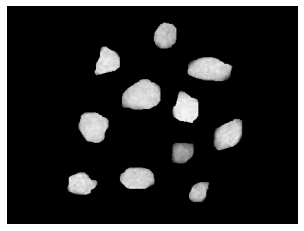

In [4]:
# Perform basic pre-processing of the image by converting it into grey-scale.
nocontacts_grey = cv2.cvtColor(no_contacts, cv2.COLOR_BGR2GRAY)

# Display the grey-scaled image as an output below.
plt.imshow(nocontacts_grey,cmap="gray")
plt.axis("off")

#### *__NB.__ Alternatively, when the actual test data (CZI files) becomes available, these files must be loaded and converted via different means:*

In [5]:
# Install a specialised Python library in order to read in CZI data files:
     # pip install czifile

# Import the imread function from this library:
     # from czifile import imread

# Open CZI files (e.g. containing lightsheet optical slices) and load automatically as a numpy array:
     # optical_slice = imread("filename.czi")

# Print to screen the starting shape of this numpy array:
     # print(first_slice.shape)

# "Slice" the elements of the array into another given index and assign to a variable with the suffix "array".
# This converts to a numpy array shape comprising the desired graphical parameters for further analysis of the image data:
     # slice_array = optical_slice[0,0,:,:,0]

# Once again, return the new shape of the array to ensure that it has indeed been changed:
     # print(slice_array.shape)

#### *Now separate the cell objects in the image by generating the markers as local maxima of the distance to the background:*

In [6]:
# Perform an exact Euclidean distance transform on the image data and assign this output as a varible with the suffix of "distance".
# Input data can be of any type and will be converted into binary: 1 = input equates to True, 0 = elsewhere.
nocontacts_distance = ndi.distance_transform_edt(nocontacts_grey)

In [7]:
# Find local maxima peaks in the image as a coordinate list, assigned with the suffix of "coords".
# Search for peaks throughout all of the input image and return a new array of a given type and shape.
nocontacts_coords = peak_local_max(nocontacts_distance, min_distance=11)

# DEBUGGING ANNOTATION:
# The first piece of code that I originally implemented here was written to return the new array as a 3 x 3 matrix, filled with ones.

# INITIAL, INCORRECT COMMAND: 
# withoutcontacts_coords = peak_local_max(withoutcontacts_distance, footprint=np.ones((3, 3)), labels=withoutcontacts_grey)
# Using this old command, the segmentation failed to run and returned "IndexError: index -1 is out of bounds for axis 0 with size 0".
# New command to replace this now specifies the minimum distance allowed between separating peaks, i.e. when searching for the local maximas.

In [8]:
# Return a new masked array of a given shape and data type = boolean, filled with zeros and corresponding to the above.
nocontacts_mask = np.zeros(nocontacts_distance.shape, dtype=bool)

In [9]:
# Combine into an ordered tuple container and set local maxima peaks to true.
# Masked arrays typically contain missing or invalid entries and so can represent datasets that are incomplete or comprise NaNs.
nocontacts_mask[tuple(nocontacts_coords.T)] = True

In [10]:
# Label any features in the overall array.
# Any non-zero values in the input are counted as features and any zero values are considered as background.
nocontacts_markers, _ = ndi.label(nocontacts_mask)

In [11]:
# Find watershed basins in the image flooded from given markers.
# Only points at which mask == True will be labelled, where features/objects are present - i.e. the fluorescent cells.
nocontacts_labels = watershed(-nocontacts_distance, nocontacts_markers, mask=nocontacts_grey)

#### *Visualise the segmented image as a final figure, revealing whether all cell regions have been successfully separated out:*

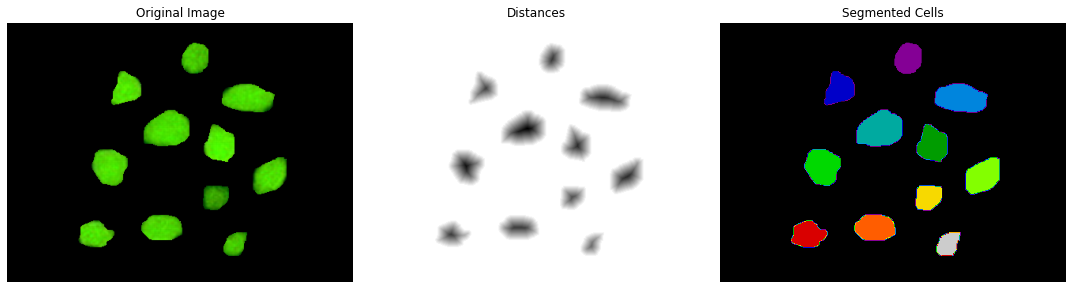

In [12]:
# Use the matplotlib library to apply a figure container within which the segmented elements can be plotted/displayed.
# Define a subplot grid with 3 columns, and x (sharex) and y (sharey) axes shared among all subplots.
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

# Specify axis characteristics and titles for each of the columns, remembering zero-based indexing.
# For the first column, view the starting image in the default colourmap:
ax[0].imshow(no_contacts)
ax[0].set_title('Original Image')

# For the second column, set the colourmap to grey-scale:
ax[1].imshow(-nocontacts_distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')

# For the third and final column, set the colourmap to a multicoloured spectrum:
ax[2].imshow(nocontacts_labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Segmented Cells')

# Turn the x- and y-axis off - refers to all axis lines, ticks, ticklabels, grid and axis labels.
for a in ax:
    a.set_axis_off()

# Adjust padding around the plot in notebook.
fig.tight_layout()

# Display the finalised figure.
plt.show()

#### *Extract out the above segmented cell regions and save each into individual TIFF files:*

In [13]:
# Find all cells that have been segmented in the above labelled array.
# Assign output to varible named "nocontacts_cells".
nocontacts_cells = ndi.find_objects(nocontacts_labels)

In [14]:
# Create a for loop to loop over each segmented cell region in the array:
# Saving them iteratively and separately into their own TIFF image files...
# ...with each given filename being "NC_Cell_X" where X is the index of the segmented cell plus 1 to account for zero-bound indexing.
for index, cell in enumerate(nocontacts_cells):
    plt.imsave('NC_Cell_'+str(index+1)+'.tiff',nocontacts_labels[cell])

#### *Finally, repeat the above coding pipeline to process and segment the second image (comprising cell cross-sections __WITH__ fluorescence overlap):*

(-0.5, 437.5, 327.5, -0.5)

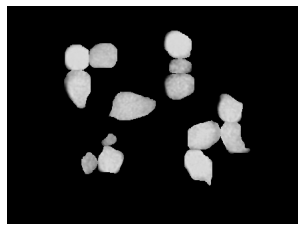

In [15]:
with_contacts = io.imread("With_Contacts.tif")

withcontacts_grey = cv2.cvtColor(with_contacts, cv2.COLOR_BGR2GRAY)

plt.imshow(withcontacts_grey,cmap="gray")
plt.axis("off")

In [16]:
withcontacts_distance = ndi.distance_transform_edt(withcontacts_grey)

withcontacts_coords = peak_local_max(withcontacts_distance, min_distance=8)

withcontacts_mask = np.zeros(withcontacts_distance.shape, dtype=bool)

withcontacts_mask[tuple(withcontacts_coords.T)] = True

withcontacts_markers, _ = ndi.label(withcontacts_mask)

withcontacts_labels = watershed(-withcontacts_distance, withcontacts_markers, mask=withcontacts_grey)

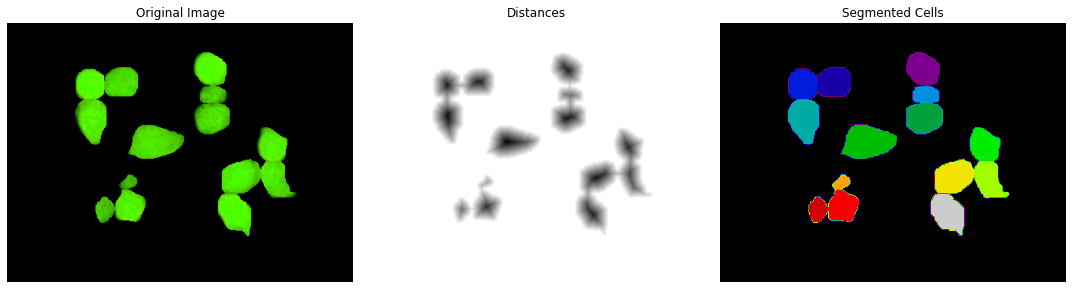

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(with_contacts)
ax[0].set_title('Original Image')

ax[1].imshow(-withcontacts_distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')

ax[2].imshow(withcontacts_labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Segmented Cells')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [18]:
withcontacts_cells = ndi.find_objects(withcontacts_labels)

for index, cell in enumerate(withcontacts_cells):
    plt.imsave('WC_Cell_'+str(index+1)+'.tiff',withcontacts_labels[cell])